# Classification with Hidden Markov Models
Running this notebook will:

- load data generated by `01_generate_data.ipynb` from file chosen in setup part
- split data into train and test subsets with chosen ratio
- fit Hidden Markov Models using both AIC and BIC criteria for selection of number of hidden states
- show comparison of number of hidden states in true and fitted models
- run classification on test subset and show results for both AIC and BIC versions in form of confusion matrices
- save results and information about used data filename and split id in pickle file

## Setup

In [1]:
import pandas as pd
import numpy as np
from hmmlearn import hmm
import pickle
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import utils
import time
from ARIMA import *
from model_class import *

RESULTS_DIR = "results"
DATA_PICKLE_FILE = "generated_data/HMM_data_ntrain5_1658502416.pkl"
SEARCH_SPACE = list(range(1,10)) # numbers of hidden states to try
SPLIT_ID = 0                    # indices of samples are grouped into train and test 

In [2]:
def fit_with_known_no_hidden_states(samples: list[np.ndarray], no_hidden_states: int, trials: int) -> hmm.GaussianHMM:
    """Fit GaussianHMM when number of hidden states is known.
    EM Algorithm will stuck in local optima, so it is recommended to try to fit model multiple times 
    and select the one with highest score. Number of iterations is set via `trials` argument.
    """
    lengths = [len(sample) for sample in samples]
    X = np.concatenate(samples)
    best_model = None
    best_score = -np.infty
    for t in range(trials):
        remodel = hmm.GaussianHMM(n_components = no_hidden_states).fit(X, lengths)
        if not remodel.monitor_.converged:
            print(f"Model in trial {t} didn't converge.") 
        score = remodel.score(X)
        if score > best_score:
            best_model = remodel
            best_score = score
    return best_model

def AIC(samples: list[np.ndarray], model: hmm.BaseHMM) -> float:
    """Akaike Information Criterion implemented for Hidden Markov Model."""
    lengths = [len(sample) for sample in samples]
    X = np.concatenate(samples)
    loglik = model.score(X, lengths)
    k = model.n_components
    return 2*k - 2*loglik

def BIC(samples: list[np.ndarray], model: hmm.BaseHMM) -> float:
    """Bayesian Information Criterion implemented for Hidden Markov Model."""
    lengths = [len(sample) for sample in samples]
    X = np.concatenate(samples)
    loglik = model.score(X, lengths)
    k = model.n_components
    n = sum(lengths) # TODO jak to dziala jak to rozbijam na czesci?
    return k*np.log(n) - 2*loglik

def fit_and_compute_criteria(samples: list[np.ndarray], search_space: list[int], trials: int) -> dict:
    """Return dict containing models and corresponding information criteria values."""
    models = [fit_with_known_no_hidden_states(samples, nhs, trials) for nhs in search_space]
    AICs = [AIC(samples, model) for model in models]
    BICs = [BIC(samples, model) for model in models]
    return {"models": models, "AIC": AICs, "BIC": BICs}

def fit_best_model(samples: list[np.ndarray], search_space: list[int], trials: int = 10, criterion: str = "AIC") -> hmm.BaseHMM:
    """Fit hmm.GaussianHMM models for all number of hidden states in `search_space` and return the one selected
    by given criterion."""
    results = fit_and_compute_criteria(samples, search_space, trials)
    best_model_id = np.argmin(results[criterion]) # Information criteria are minimized, not maximized.
    return results["models"][best_model_id]

def classify_sample(X: np.ndarray, fitted_models: list[hmm.BaseHMM]) -> int:
    """Return id of fitted model with best log-likelihood given (one) sample X."""
    scores = [model.score(X) for model in fitted_models]
    return np.argmax(scores)

## Load data and prepare train and test subsets

In [3]:
with open(DATA_PICKLE_FILE, "rb") as f:
    data = pickle.load(f)

data.keys()

dict_keys(['generating_model', 'data_filename', 'time_index', 'models_lst', 'labels_df', 'all_X_samples', 'all_Z_samples', 'indices_splits_lst', 'metadata'])

In [4]:
print(data["models_lst"][0])

GaussianHMM(n_components=2)


In [5]:
print(data["metadata"])

{'N_TRAIN_SAMPLES_PER_MODEL': 5, 'N_TEST_SAMPLES_PER_MODEL': 30, 'MAX_SAMPLE_LEN': 50, 'MIN_SAMPLE_LEN': 20}


In [6]:
indices_splits_lst = data["indices_splits_lst"]
all_X_samples = data["all_X_samples"]
labels_df = data["labels_df"]
current_split = indices_splits_lst[SPLIT_ID]
train_samples_ids = current_split["train_samples_ids"]
test_samples_ids = current_split["test_samples_ids"]

## Fit the models: use both AIC and BIC

In [7]:
fitted_models_AIC = []
fitted_models_BIC = []
start = time.time()
for label, sub_df in labels_df.loc[train_samples_ids].groupby("true_label"):
    int_ids = sub_df.index.values.astype('int')
    X = [all_X_samples[id] for id in int_ids]
    fitted_models_AIC.append(fit_best_model(X, SEARCH_SPACE, criterion="AIC"))
    fitted_models_BIC.append(fit_best_model(X, SEARCH_SPACE, criterion="BIC"))
stop = time.time()
fit_AIC_BIC_time = stop - start

### Compare numbers of hidden states fitted and true models (if true models are HMM)

In [8]:
if hasattr(data["models_lst"][0], "n_components"):
    true_models = data["models_lst"]
    print("Number of hidden states in model used to generate samples vs fitted model:")
    print("label |true k |fitted k (AIC) |fitted k (BIC)")
    for i in range(len(fitted_models_AIC)):
        k_true = true_models[i].n_components
        k_fit_AIC = fitted_models_AIC[i].n_components
        k_fit_BIC = fitted_models_BIC[i].n_components
        print(f"{i}     |{k_true}      |{k_fit_AIC}              |{k_fit_BIC}")

else:
    print("True models don't have n_hidden states - nothing to compare.")

Number of hidden states in model used to generate samples vs fitted model:
label |true k |fitted k (AIC) |fitted k (BIC)
0     |2      |3              |2
1     |2      |2              |2
2     |2      |3              |3
3     |1      |4              |1
4     |1      |3              |1
5     |1      |2              |2
6     |5      |8              |8
7     |3      |3              |3
8     |3      |3              |3


## Classify test samples

In [9]:
test_df = labels_df.loc[test_samples_ids]
int_ids = test_df.index.values.astype('int')
test_samples = [all_X_samples[id] for id in int_ids]

start = time.time()
predictions_AIC = [classify_sample(X, fitted_models_AIC) for X in test_samples]
predictions_BIC = [classify_sample(X, fitted_models_BIC) for X in test_samples]
stop = time.time()
classify_all_time = stop - start

predictions_df = pd.DataFrame({
    "pred_AIC": predictions_AIC,
    "pred_BIC": predictions_BIC
}, index= test_df.index)

classification_results = test_df.join(predictions_df)
classification_results.head()

,sample_id,true_label,sample_len,pred_AIC,pred_BIC
0,0,0,32,0,0
2,2,0,20,0,0
4,4,0,23,0,0
5,5,0,41,0,0
6,6,0,20,1,1


In [10]:
fit_predict_time = fit_AIC_BIC_time + classify_all_time
print(f"Time needed to fit models and make predictions: {fit_predict_time:.2f}s")

Time needed to fit models and make predictions: 48.73s


### Show confusion matrices

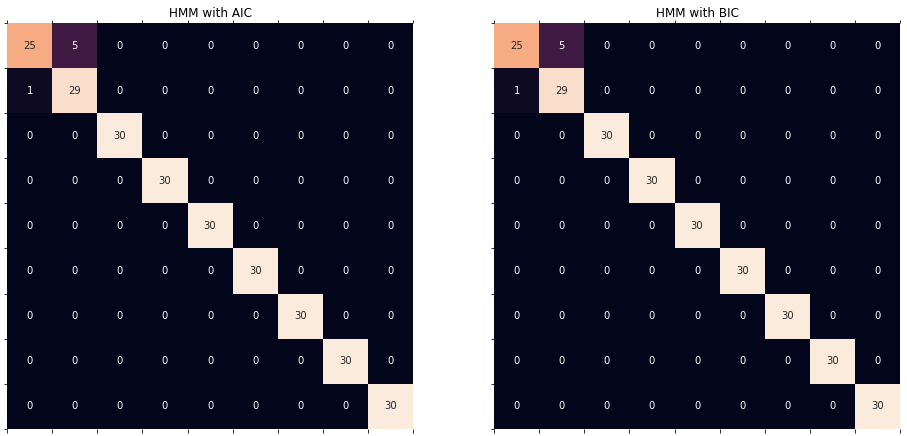

In [11]:
y_true = classification_results["true_label"]
y_pred_AIC = classification_results["pred_AIC"]
y_pred_BIC = classification_results["pred_BIC"]

cm_AIC = confusion_matrix(y_true, y_pred_AIC)
cm_BIC = confusion_matrix(y_true, y_pred_BIC)

plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams['font.size'] = 10
fig, axes = plt.subplots(ncols = 2)
sns.heatmap(cm_AIC, annot=True, fmt='g', ax=axes[0], cbar = False)
axes[0].matshow(cm_AIC)
axes[0].set_title("HMM with AIC")
sns.heatmap(cm_BIC, annot=True, fmt='g', ax=axes[1], cbar = False)
axes[1].matshow(cm_BIC)
axes[1].set_title("HMM with BIC")
plt.show()

In [12]:
accuracies = dict()
true = classification_results["true_label"]
for col in utils.find_colnames_with(classification_results):
    acc = utils.accuracy(true, classification_results[col])
    accuracies[col] = acc
    print(f"{col} accuracy: {acc:.4f}")

pred_AIC accuracy: 0.9778
pred_BIC accuracy: 0.9778


## Save classification results

In [13]:
time_index = data["time_index"]
summary = {
    "data_filename": DATA_PICKLE_FILE,
    "time_index": time_index,
    "split_id": SPLIT_ID,
    "results_df": classification_results,
    "accuracies": accuracies,
    "total_time": fit_predict_time
}

for key, val in summary.items():
    print(f"{key}: {val}")

data_filename: generated_data/HMM_data_ntrain5_1658502416.pkl
time_index: 1658502416
split_id: 0
results_df:      sample_id  true_label  sample_len  pred_AIC  pred_BIC
0            0           0          32         0         0
2            2           0          20         0         0
4            4           0          23         0         0
5            5           0          41         0         0
6            6           0          20         1         1
..         ...         ...         ...       ...       ...
309        309           8          47         8         8
310        310           8          26         8         8
311        311           8          44         8         8
313        313           8          50         8         8
314        314           8          35         8         8

[270 rows x 5 columns]
accuracies: {'pred_AIC': 0.9777777777777777, 'pred_BIC': 0.9777777777777777}
total_time: 48.732128381729126


In [14]:
gen_type = data["generating_model"]
split_id_str = str(SPLIT_ID)
if len(split_id_str) == 1:
    split_id_str = "0" + split_id_str

output_path = f"{RESULTS_DIR}/hmm_results_for_{gen_type}_{time_index}_{split_id_str}.pkl"
with open(output_path, 'wb') as f:
    pickle.dump(summary, f)
    print(f"Classification results saved to {output_path}.")

Classification results saved to results/hmm_results_for_HMM_1658502416_00.pkl.
